In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import *

import warnings
warnings.filterwarnings("ignore")

In [3]:
# data
winddir=pd.read_csv("winddir.csv")
winddir['Datetime'] = pd.to_datetime(winddir.Datetime, format='%Y/%m/%d')
data=np.asarray(winddir.iloc[:,1])
# 此时train和test都是ndarray

sep=int(len(data)*0.8)

# sin, cos, tan

In [5]:
sindata,cosdata=data.copy(),data.copy()
for i in range(len(data)):
    sindata[i]=sin(radians(data[i]))
    cosdata[i]=cos(radians(data[i]))

In [15]:
def todeg(sinv,cosv):
    """根据sin值和cos值得到角度制的角度，输入分别为sin和cos"""
    if cosv==0:
        if sinv>=0:
            return 90
        else:
            return 270
    tanv=sinv/cosv
    ans=atan(tanv)
    if cosv<0:
        ans+=pi
    if cosv>0 and tanv<0:
        ans+=2*pi
    return degrees(ans)

In [16]:
todeg(-0.5,0.5)

315.0

# 尝试AR

In [44]:
from statsmodels.tsa.ar_model import AutoReg
trains,tests,trainc,testc = sindata[:sep],sindata[sep:],cosdata[:sep],cosdata[sep:]

In [45]:
# 从1至10遍历找最优自回归阶数,sin
bestlags,mse=1,100
for i in range(10):
    ar = AutoReg(trains,lags=i,trend='n',seasonal=True,period=365).fit()  #
    ar_fit = ar.predict(start=0,end=len(trains)-1+i)  # 我们进行拟合
    if mse > mean_squared_error(trains,ar_fit):
        bestlags, mse = i, mean_squared_error(trains,ar_fit)
    
ar = AutoReg(trains,lags=bestlags,trend='n',seasonal=True,period=365).fit()  #
sin_fit = ar.predict(start=0,end=len(trains)-1+bestlags)
sin_pre = ar.predict(start=len(trains),end=len(trains)+len(tests)-1)  # 这里是预测了

bestlags

1

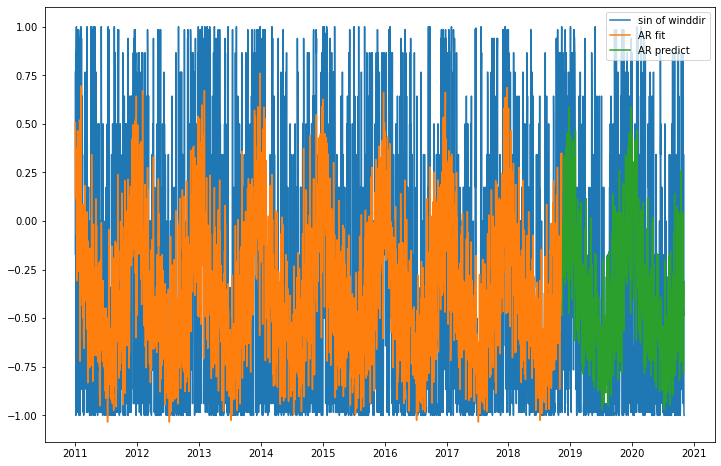

In [46]:
plt.figure(figsize=(12, 8))
plt.plot(winddir.Datetime, sindata, label='sin of winddir')
plt.plot(winddir.Datetime[:sep], sin_fit, label='AR fit')
plt.plot(winddir.Datetime[sep:], sin_pre, label='AR predict')
plt.legend()

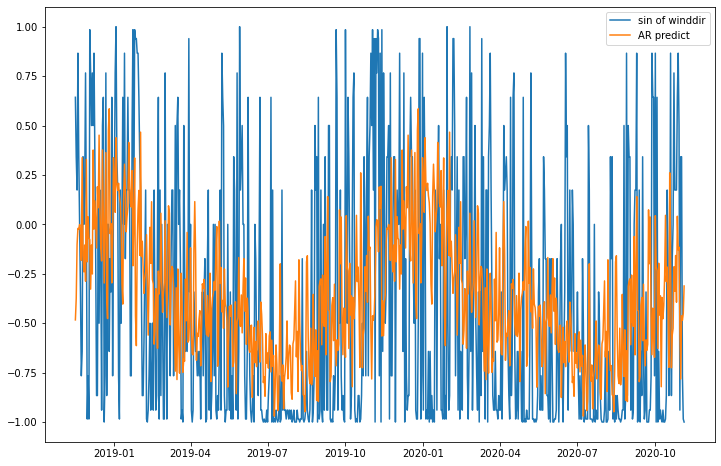

In [47]:
# 这个图只有预测的部分
plt.figure(figsize=(12, 8))
plt.plot(winddir.Datetime[sep:], sindata[sep:], label='sin of winddir')
# plt.plot(winddir.Datetime[:sep], sin_fit, label='AR fit')
plt.plot(winddir.Datetime[sep:], sin_pre, label='AR predict')
plt.legend()

In [48]:
# mean square error
mse = mean_squared_error(tests,sin_pre)
print("mse of AR: ", mse)
# 0.41906165452966665

mse of AR:  0.41906165452966665


In [49]:
# 从1至10遍历找最优自回归阶数,cos
bestlags,mse=1,100
for i in range(10):
    ar = AutoReg(trainc,lags=i,trend='n',seasonal=True,period=365).fit()  #
    ar_fit = ar.predict(start=0,end=len(trainc)-1+i)  # 我们进行拟合
    if mse > mean_squared_error(trainc,ar_fit):
        bestlags, mse = i, mean_squared_error(trainc,ar_fit)
    
ar = AutoReg(trainc,lags=bestlags,trend='n',seasonal=True,period=365).fit()  #
cos_fit = ar.predict(start=0,end=len(trainc)-1+bestlags)
cos_pre = ar.predict(start=len(trainc),end=len(trainc)+len(testc)-1)  # 这里是预测了

bestlags

1

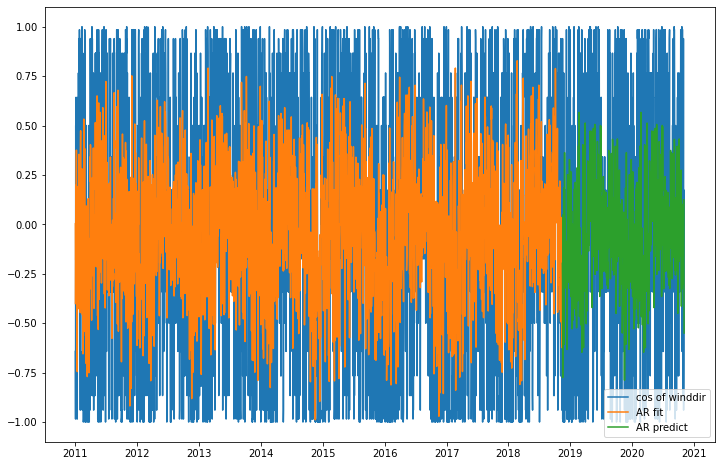

In [50]:
plt.figure(figsize=(12, 8))
plt.plot(winddir.Datetime, cosdata, label='cos of winddir')
plt.plot(winddir.Datetime[:sep], cos_fit, label='AR fit')
plt.plot(winddir.Datetime[sep:], cos_pre, label='AR predict')
plt.legend()

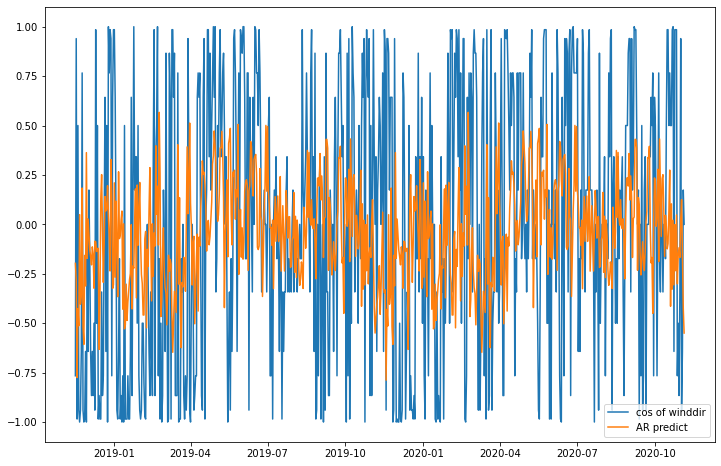

In [51]:
# 这个图只有预测的部分
plt.figure(figsize=(12, 8))
plt.plot(winddir.Datetime[sep:], cosdata[sep:], label='cos of winddir')
# plt.plot(winddir.Datetime[:sep], cos_fit, label='AR fit')
plt.plot(winddir.Datetime[sep:], cos_pre, label='AR predict')
plt.legend()

In [53]:
# mean square error
mse = mean_squared_error(testc,cos_pre)
print("mse of AR: ", mse)
# 0.4747842400737545

mse of AR:  0.4747842400737545


# 通过sin和cos还原角度

In [54]:
ar_fit,ar_pre=sin_fit.copy(),sin_pre.copy()
for i in range(len(ar_fit)):
    ar_fit[i]=todeg(sin_fit[i],cos_fit[i])
for i in range(len(ar_pre)):
    ar_pre[i]=todeg(sin_pre[i],cos_pre[i])

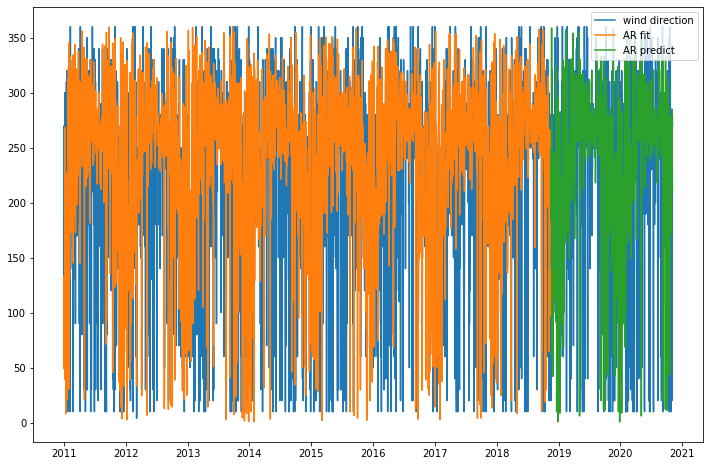

In [55]:
plt.figure(figsize=(12, 8))
plt.plot(winddir.Datetime, data, label='wind direction')
plt.plot(winddir.Datetime[:sep], ar_fit, label='AR fit')
plt.plot(winddir.Datetime[sep:], ar_pre, label='AR predict')
plt.legend()

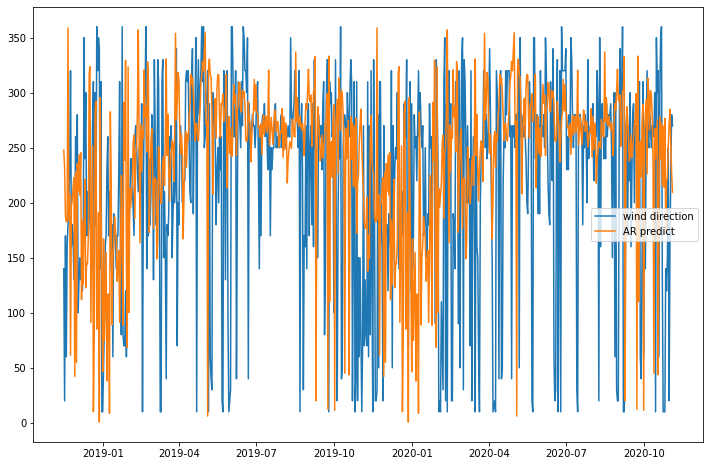

In [56]:
# 这个图只有预测的部分
plt.figure(figsize=(12, 8))
plt.plot(winddir.Datetime[sep:], data[sep:], label='wind direction')
# plt.plot(winddir.Datetime[:sep], ar_fit, label='AR fit')
plt.plot(winddir.Datetime[sep:], ar_pre, label='AR predict')
plt.legend()

In [57]:
# mean square error
mse = mean_squared_error(data[sep:],ar_pre)
print("mse of AR: ", mse)
# 13739.586889301867

mse of AR:  13739.586889301867


In [58]:
pd.DataFrame(np.concatenate([ar_fit,ar_pre])).to_csv('result_AR_winddir.csv',index = False)
# 预测的结果，有预测值和拟合值